# Was importiert Deutschland aus den USA?

## Data

- Impex 2d: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0007
- Impex 4d
- Impex 8d: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0015

## Notes

- Combined Nomenclature: https://taxation-customs.ec.europa.eu/customs-4/calculation-customs-duties/customs-tariff/combined-nomenclature_de
- a.n.g. = anderweitig nicht genannt


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import squarify
import sys
import json
from io import StringIO
from tqdm import tqdm
tqdm.pandas()
from dotenv import dotenv_values
secrets = dotenv_values(".env") 

sys.path.append('..')
from utils.get_destatis_variable_values import get_destatis_variable_values
from utils.get_destatis_table import get_destatis_table
from utils.try_cache import try_cache

In [2]:
# Own research
food_codes_2d = [
    "WA01",
    "WA02",
    "WA03",
    "WA04",
    "WA05",
    "WA07",
    "WA08",
    "WA09",
    "WA10",
    "WA11",
    "WA15",
    "WA16",
    "WA17",
    "WA18",
    "WA19",
    "WA20",
    "WA21",
    "WA22",
]

raw = {}
data = {}

In [3]:
raw["impex2d"] = pd.read_csv("./data/51000-0007_de_flat.csv",
                               	delimiter=";",
                               	decimal=",",
                               	thousands=".",
                               	parse_dates=["time"],
                               	converters={ "value": lambda x: pd.to_numeric(x, errors="coerce")})

raw["impex8d"] =  pd.read_csv("./data/51000-0013_de_flat.csv",
								delimiter=";",
								decimal=",",
								thousands=".",
								parse_dates=["time"],
								converters={"value": lambda x: pd.to_numeric(x, errors="coerce")})

In [4]:
raw["country_codes"] = try_cache("./data/genesis-countries.json", lambda: get_destatis_variable_values(var="STLAH", token=secrets["DESTATIS_TOKEN"]))
data["country_codes"] = pd.DataFrame(data=json.loads(raw["country_codes"])["List"])

raw["product_codes_4d"] = try_cache("./data/genesis-products-4d.json", lambda: get_destatis_variable_values(var="WAM4", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_4d"] = pd.DataFrame(data=json.loads(raw["product_codes_4d"])["List"])

raw["product_codes_6d"] = try_cache("./data/genesis-products-6d.json", lambda: get_destatis_variable_values(var="WAM6", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_6d"] = pd.DataFrame(data=json.loads(raw["product_codes_6d"])["List"])

In [5]:
food_codes_4d = data["product_codes_4d"].loc[data["product_codes_4d"]["Code"].str[:4].isin(food_codes_2d)]["Code"]
food_codes_6d = data["product_codes_6d"].loc[data["product_codes_6d"]["Code"].str[:4].isin(food_codes_2d)]["Code"]
food_codes_6d.values

array(['WA010110', 'WA010121', 'WA010129', ..., 'WA229799', 'WA229899',
       'WA229999'], dtype=object)

In [12]:
def parse_genesis_csv(csv):
	return pd.read_csv(StringIO(csv),
            	header=5,
            	skiprows=[6],
            	skipfooter=3,
            	delimiter=";",
            	decimal=",",
            	thousands=".",
            	engine="python",
            	parse_dates=["Unnamed: 0"],
            	converters=destatis_converters
				).rename(columns={
    				"Unnamed: 0": "year",
    				"Unnamed: 1": "country",
    				"Unnamed: 2": "product_code",
    				"Unnamed: 3": "product_label",
				})
	
destatis_converters = {
	"Ausfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce")
}

def get_paged_destatis_table(codes: list[str], codes_per_request: int = 1, dry_run = False):
	chunks = [codes[i:i + codes_per_request] for i in range(0, len(codes), codes_per_request)]
	result = pd.DataFrame()
	print(f"Received {len(codes)} attribute codes, generated {len(chunks)} chunks")
	if (dry_run):
		return
	with tqdm(total=len(chunks), unit=" chunks") as bar:
		for i, chunk in enumerate(chunks):
			bar.set_description(f"[{','.join(chunk)}]")
			t = try_cache(f"./data/impex-6d/{'_'.join(chunk)}.csv",
				lambda: get_destatis_table(
					token=secrets["DESTATIS_TOKEN"],
					password=secrets["DESTATIS_PASSWORD"],
					tables=["51000-0009"],
					start_year=2024,
					attributes={"STLAH": "*", "WAM6": ",".join(chunk)},
					silent=False,
					skip_credential_validation=(i > 0)), silent=True
			)
			d = parse_genesis_csv(t)
			result = pd.concat([result, d])
			bar.update(1)

	return result

data["impex4d"] = get_paged_destatis_table(food_codes_6d.values, codes_per_request=5, dry_run=False)


Received 1020 attribute codes, generated 204 chunks


[WA220900,WA229699,WA229799,WA229899,WA229999]: 100%|██████████| 204/204 [00:12<00:00, 16.94 chunks/s]   


In [8]:
data["impex2d"] =  raw["impex2d"][["statistics_code", "time","1_variable_attribute_label", "2_variable_attribute_label", "3_variable_attribute_code", "3_variable_attribute_label", "value", "value_unit", "value_variable_label", "value_q"]].rename(columns={
        "1_variable_attribute_label": "destination",
        "2_variable_attribute_label": "origin",
        "3_variable_attribute_code": "product_code",
        "3_variable_attribute_label": "product_label",
	})

data["impex8d"] =  raw["impex8d"][
    ["time", "value_variable_label", "value", "value_unit","1_variable_attribute_label", "2_variable_attribute_code","2_variable_attribute_label", "statistics_code","value_q"]
    ].rename(columns={
        "2_variable_attribute_code": "product_code",
        "2_variable_attribute_label": "product_label",
	})

## Analyse
> Also ich würde mal sagen, welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert? Und ideal wäre es, wenn man das noch ins Verhältnis setzen könnte: Deutschland verarbeitet pro Jahr XX Tonnen Mandeln. XX Prozent davon werden aus dem Ausland importiert und der Anteil der USA an den Importen beträgt XX Prozent. Das wäre meine Wunschvorstellung.
([via Teams](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744359699218?context=%7B%22contextType%22%3A%22chat%22%7D))

### 1. Welche Soja-Produkte importieren wir aus den USA?


In [9]:
soy_codes = [
    "WA12019000",
    "WA12081000",
    "WA15071090",
    "WA15079090",
    "WA21031000",
    "WA22029911",
    "WA22029915"
]

pd.set_option('display.max_colwidth', None)
d = data["impex8d"].loc[
    (data["impex8d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex8d"]["product_label"].str.contains("Soja"))
].sort_values("value", ascending=False)[["time", "product_label", "product_code", "value", "value_unit"]]

d

,time,product_label,product_code,value,value_unit
71189,2024-01-01,"Sojabohnen, auch geschrotet, a.n.g.",WA12019000,1630299.0,Tsd. EUR
26877,2024-01-01,Ölkuchen u.a. feste Rückstände von Sojaöl,WA23040000,1120665.0,Tsd. EUR
54501,2024-01-01,"Getränke aus Soja, Nüssen, Samen, a.n.g. l",WA22029915,190950.0,Tsd. EUR
71845,2024-01-01,"Rohes Sojaöl, zur Verwendung als Lebensmittel",WA15071090,56707.0,Tsd. EUR
106981,2024-01-01,"Sojasoße, zubereitet",WA21031000,50471.0,Tsd. EUR
53749,2024-01-01,"Sojaöl, raffiniert, zu Lebensmittelzwecken",WA15079090,48251.0,Tsd. EUR
19653,2024-01-01,"Rohes Sojaöl, zu industriellen Zwecken",WA15071010,38385.0,Tsd. EUR
53765,2024-01-01,"Getränke aus Soja, Eiweißgehalt >= 2,8 GHT l",WA22029911,36122.0,Tsd. EUR
18837,2024-01-01,Mehl von Sojabohnen,WA12081000,9238.0,Tsd. EUR
87621,2024-01-01,Sojabohnen zur Aussaat,WA12011000,5822.0,Tsd. EUR



> Also ich würde mal sagen, welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert? Und ideal wäre es, wenn man das noch ins Verhältnis setzen könnte: Deutschland verarbeitet pro Jahr XX Tonnen Mandeln. XX Prozent davon werden aus dem Ausland importiert und der Anteil der USA an den Importen beträgt XX Prozent. Das wäre meine Wunschvorstellung.
([via Teams](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744359699218?context=%7B%22contextType%22%3A%22chat%22%7D))

### Welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert?
In der Außenhandelsstatistik werden Produkte in Gruppen verschiedener Detailstufen aufgeteilt.

Unter **2-stelligen Warengruppen** waren die zehn größten Lebensmittelimporte im Jahr 2024, gemessen nach Wert in Euro: Genießbare Früchte und Nüsse (`WA08`), Getränke, alkoholhaltige Flüssigkeiten, Essig (`WA22`), Fische, Krebs- und Weichtiere (`WA03`), Lebensmittelzubereitungen (`WA21`), Zubereitungen von Gemüse/Früchten (`WA20`), Gemüse (`WA07`), Fleisch (`WA02`), andere Tierprodukte (`WA05`), Fette und Öle (`WA15`), und Kakao und Zubereitungen (`WA18`).

Unter **6-stelligen Warengruppen** waren die zehn größten Lebensmittelimporte im gleichen Zeitraum:  Pistazien in der Schale (`WA080251`), Mandeln ohne Schale (`WA080212`), Whisky (`WA220830`), Filets vom Pazifischen Pollack (`WA030475`), Walnüsse ohne Schale (`WA080232`), Lebensmittelzubereitungen (`WA210690`), Pistazien ohne Schale (`WA080252`), Wein (`WA220421`), Preiselbeeren und Moosbeeren, zubereitet (`WA200893`), und Weintrauben (`WA080610`).


In [95]:
# 2-stellige Warengruppen
top_imports_2d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(food_codes_2d))
].nlargest(10, ["value"])

top_imports_2d[["time", "origin", "product_code", "product_label", "value", "value_unit"]]


,time,origin,product_code,product_label,value,value_unit
95759,2024-01-01,Vereinigte Staaten von Amerika,WA08,Genießbare Früchte und Nüsse,912342.0,Tsd. EUR
102065,2024-01-01,Vereinigte Staaten von Amerika,WA22,"Getränke, alkoholhaltige Flüssigkeiten, Essig",255691.0,Tsd. EUR
96485,2024-01-01,Vereinigte Staaten von Amerika,WA03,"Fische, Krebs- und Weichtiere",187111.0,Tsd. EUR
102215,2024-01-01,Vereinigte Staaten von Amerika,WA21,Verschiedene Lebensmittelzubereitungen,133619.0,Tsd. EUR
102365,2024-01-01,Vereinigte Staaten von Amerika,WA20,"Zubereitungen von Gemüse, Früchten usw.",61437.0,Tsd. EUR
95921,2024-01-01,Vereinigte Staaten von Amerika,WA07,"Gemüse, Pflanzen für Ernährung",42963.0,Tsd. EUR
96587,2024-01-01,Vereinigte Staaten von Amerika,WA02,Fleisch,31596.0,Tsd. EUR
96209,2024-01-01,Vereinigte Staaten von Amerika,WA05,Andere Waren tierischen Ursprungs,29138.0,Tsd. EUR
101411,2024-01-01,Vereinigte Staaten von Amerika,WA15,"Tierische und pflanzliche Fette, Öle, Wachs",27894.0,Tsd. EUR
100901,2024-01-01,Vereinigte Staaten von Amerika,WA18,Kakao und Zubereitungen aus Kakao,22296.0,Tsd. EUR


In [30]:
top_imports_6d = data["impex4d"].loc[
    data["impex4d"]["country"] == "Vereinigte Staaten von Amerika"
	].nlargest(10, ["Einfuhr: Wert"])[["year", "country","product_code", "product_label", "Einfuhr: Wert", "Einfuhr: Gewicht"]]
top_imports_6d

,year,country,product_code,product_label,Einfuhr: Wert,Einfuhr: Gewicht
857,2024-01-01,Vereinigte Staaten von Amerika,WA080251,"Pistazien in der Schale, frisch oder getrocknet",313278.0,48012.0
858,2024-01-01,Vereinigte Staaten von Amerika,WA080212,"Mandeln, frisch oder getrocknet, ohne Schale",234028.0,54447.2
859,2024-01-01,Vereinigte Staaten von Amerika,WA220830,Whisky,164607.0,25158.1
855,2024-01-01,Vereinigte Staaten von Amerika,WA030475,"Filets vom Pazifischen Pollack, gefroren",132401.0,40480.1
857,2024-01-01,Vereinigte Staaten von Amerika,WA080232,"Walnüsse ohne Schale, frisch oder getrocknet",131712.0,30701.3
855,2024-01-01,Vereinigte Staaten von Amerika,WA210690,"Lebensmittelzubereitungen, a.n.g.",86963.0,4387.1
858,2024-01-01,Vereinigte Staaten von Amerika,WA080252,"Pistazien ohne Schale, frisch oder getrocknet",75089.0,5943.5
858,2024-01-01,Vereinigte Staaten von Amerika,WA220421,"Wein aus frischen Weintrauben, <=2l",35735.0,5709.9
855,2024-01-01,Vereinigte Staaten von Amerika,WA200893,"Preiselbeeren und Moosbeeren, zubereitet",30061.0,8183.6
859,2024-01-01,Vereinigte Staaten von Amerika,WA080610,"Weintrauben, frisch",27353.0,8922.3


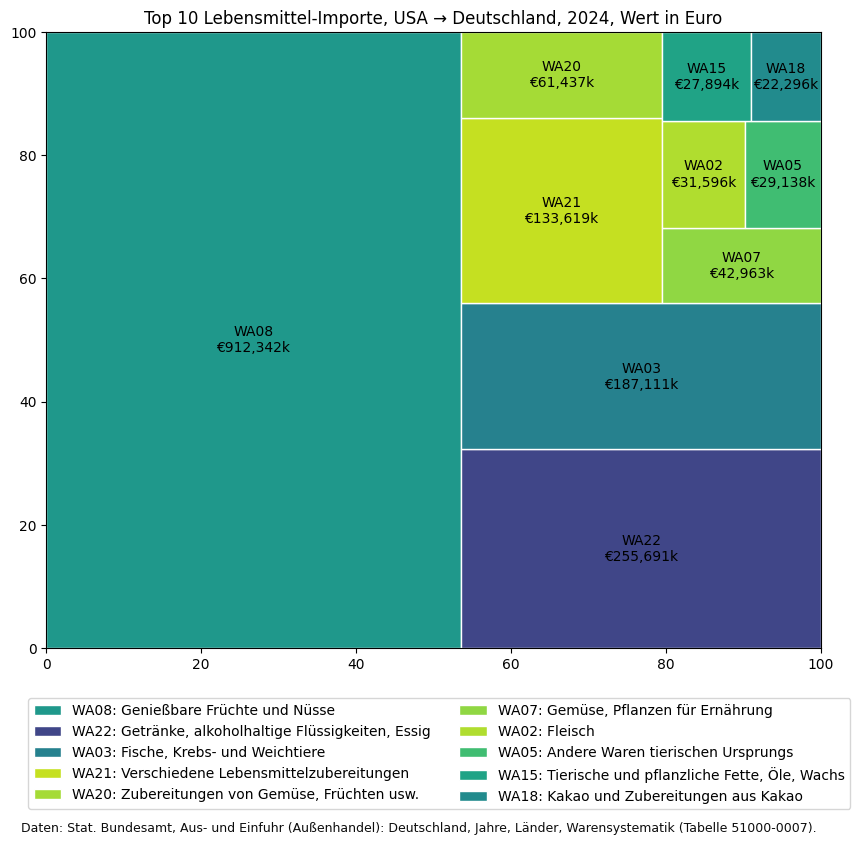

In [ ]:
d = top_imports_2d.sort_values("value", ascending=False).reset_index()[:10]

fig, ax = plt.subplots(figsize=(10,8))
plt.title("Top 10 Lebensmittel-Importe, USA → Deutschland, 2024, Wert in Euro")

d = d.sort_values("value", ascending=False)
short_label = d["product_code"] + "\n" + d["value"].apply(lambda x: f"€{round(x):,}k")
long_label = d["product_code"] + ": " + d["product_label"]
squarify.plot(d["value"], label=short_label, edgecolor="white")
fig.legend(long_label, loc="lower left", ncols=2, bbox_to_anchor=(.1, -.1, .8, 1))
ax.text(x=.1, y=-0.12, s="Daten: Stat. Bundesamt, Aus- und Einfuhr (Außenhandel): Deutschland, Jahre, Länder, Warensystematik (Tabelle 51000-0007).", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()

### Wie groß ist der Anteil der US-Importe

In [96]:
def compute_total_import_value(x, field):
	d = data["impex4d"].loc[
		(data["impex4d"]["product_code"] == x)
	]
	return d[field].sum()

result = pd.DataFrame()
for g2d in top_imports_2d["product_code"].values:
    res = data["impex4d"].loc[
        (data["impex4d"]["product_code"].str[:4] == g2d)
		& (data["impex4d"]["country"] == "Vereinigte Staaten von Amerika")
        & ~(data["impex4d"]["product_label"].str.contains("Zuschätzungen"))
	].nlargest(10, "Einfuhr: Wert")
    result = pd.concat([result, res])

result["total_import_value"] = result["product_code"].apply(lambda x: compute_total_import_value(x, "Einfuhr: Wert"))
result["total_import_weight"] = result["product_code"].apply(lambda x: compute_total_import_value(x, "Einfuhr: Gewicht"))

In [97]:
result["product_2d"] = result["product_code"].str[:4]
result["us_share_value"] = result["Einfuhr: Wert"].div(result["total_import_value"]).round(4)
result["us_share_weight"] = result["Einfuhr: Gewicht"].div(result["total_import_weight"]).round(4)

result_formatted = result[["product_label", "product_2d", "product_code", "Einfuhr: Wert", "Einfuhr: Gewicht", "total_import_value", "total_import_weight", "us_share_weight", "us_share_value"]].rename(columns={
    "product_code": "product_6d",
    "Einfuhr: Wert": "us_import_value",
    "Einfuhr: Gewicht": "us_import_weight"
})

result_formatted.to_csv("./output/imports.csv", index=False)
result_formatted

,product_label,product_2d,product_6d,us_import_value,us_import_weight,total_import_value,total_import_weight,us_share_weight,us_share_value
857,"Pistazien in der Schale, frisch oder getrocknet",WA08,WA080251,313278.0,48012.0,331379.0,50350.5,0.9536,0.9454
858,"Mandeln, frisch oder getrocknet, ohne Schale",WA08,WA080212,234028.0,54447.2,449843.0,95575.3,0.5697,0.5202
857,"Walnüsse ohne Schale, frisch oder getrocknet",WA08,WA080232,131712.0,30701.3,215143.0,47107.4,0.6517,0.6122
858,"Pistazien ohne Schale, frisch oder getrocknet",WA08,WA080252,75089.0,5943.5,185052.0,13073.6,0.4546,0.4058
859,"Weintrauben, frisch",WA08,WA080610,27353.0,8922.3,992218.0,353134.8,0.0253,0.0276
...,...,...,...,...,...,...,...,...,...
855,"Schokolade, Gewicht >2kg",WA18,WA180620,217.0,29.4,969720.0,197487.1,0.0001,0.0002
859,Kakaopulver mit Zusatz von Zucker,WA18,WA180610,49.0,2.8,15130.0,2498.9,0.0011,0.0032
858,"Kakaopulver ohne Zusatz von Zucker, Süßmitteln",WA18,WA180500,32.0,7.4,155880.0,35728.8,0.0002,0.0002
858,"Kakaobohnen und Kakaobohnenbruch, roh, geröstet",WA18,WA180100,2.0,0.1,2349446.0,397549.9,0.0000,0.0000
